<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 3

The goal is to compare `RNN` and `LSTM` on `Reuters News Wire` data.

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

## Import packages 


In [1]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,RNN, LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from tensorflow.keras.datasets import reuters

# GridSearch Dependencies
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def print_results(grid_result):
    para = pd.DataFrame.from_dict(grid_result.cv_results_['params'])
    mean = pd.DataFrame(grid_result.cv_results_['mean_test_score'],columns=['mean_test_score'])
    stds = pd.DataFrame(grid_result.cv_results_['std_test_score'],columns=['std_test_score'])
    time = pd.DataFrame(grid_result.cv_results_['mean_fit_time'],columns=['mean_fit_time'])

    df = para.join(mean.join(stds)).join(time).sort_values('mean_test_score', ascending=False)
    df.reset_index().drop(columns=['index'])
    return df

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.3.1


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Mount Google Drive to Colab Environment

In [6]:
#from google.colab import drive
#drive.mount('/content/gdrive')

## Loading Reuters dataset

We will be working with the Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, widely used toy dataset for text classification. This is a dataset of 11,228 newswires from Reuters, labeled over 46 topics. Some topics are more represented than others, but each topic has at least 10 examples in the training set.

Like MNIST and Fashion MNIST, the Reuters dataset comes packaged as part of Keras.
<div class="alert alert-block alert-success">
"Each newswire is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".</div>

<div class="alert alert-block alert-info">
<b>tf.keras.datasets.reuters.load_data</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data
</div>

In [7]:
(data, labels), (_, _) = tf.keras.datasets.reuters.load_data(
                                      path='reuters.npz', num_words=None, skip_top=0, maxlen=None, test_split=0,
                                      seed=113, start_char=1, oov_char=2, index_from=3)

## EDA Reuters Dataset

In [8]:
print(f"There are {len(data)} Reuters News Articles with {len(labels)} labels.") 
print(f"There are {len(set(labels))} different label categories.")

There are 11228 Reuters News Articles with 11228 labels.
There are 46 different label categories.


In [9]:
print(f"The first five labels: {labels[:10]}")

The first five labels: [ 3  4  3  4  4  4  4  3  3 16]


## Mapping of classes to indices 
keeps track of our mapping of label values to the label indices, where the indices are actually predicted by our model. The label_map can map the label class back to the label name.

In [10]:
class_to_idx =  \
{'copper': 6, 'livestock': 28, 'gold': 25, 
 'money-fx': 19, 'ipi': 30, 'trade': 11, 
 'cocoa': 0, 'iron-steel': 31, 'reserves': 12, 
 'tin': 26, 'zinc': 37, 'jobs': 34, 'ship': 13, 
 'cotton': 14, 'alum': 23, 'strategic-metal': 27, 
 'lead': 45, 'housing': 7, 'meal-feed': 22, 'gnp': 21, 
 'sugar': 10, 'rubber': 32, 'dlr': 40, 'veg-oil': 2, 
 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 
 'carcass': 15, 'lei': 35, 'gas': 41, 'nat-gas': 17, 
 'oilseed': 24, 'orange': 38, 'heat': 33, 'wpi': 43, 
 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 
 'hog': 44, 'acq': 4, 'pet-chem': 39, 'grain': 1, 'retail': 29}

### Report the total number of documents, classes, and frequency distribution

we reversed the `class_to_idx` dictionary above so that we can decode the labels into classes

In [11]:
idx_to_class = dict([(value, key) for (key, value) in class_to_idx.items()])
{k: idx_to_class[k] for k in list(idx_to_class)[:15]} 

{6: 'copper',
 28: 'livestock',
 25: 'gold',
 19: 'money-fx',
 30: 'ipi',
 11: 'trade',
 0: 'cocoa',
 31: 'iron-steel',
 12: 'reserves',
 26: 'tin',
 37: 'zinc',
 34: 'jobs',
 13: 'ship',
 14: 'cotton',
 23: 'alum'}

In [12]:
classes = [idx_to_class[label] for label in labels]

In [13]:
Counter(classes).most_common()

[('earn', 3972),
 ('acq', 2423),
 ('money-fx', 682),
 ('crude', 543),
 ('grain', 537),
 ('trade', 473),
 ('interest', 339),
 ('ship', 209),
 ('money-supply', 177),
 ('sugar', 154),
 ('gnp', 127),
 ('coffee', 126),
 ('gold', 123),
 ('veg-oil', 94),
 ('cpi', 86),
 ('oilseed', 81),
 ('cocoa', 67),
 ('copper', 62),
 ('reserves', 62),
 ('bop', 60),
 ('livestock', 58),
 ('ipi', 57),
 ('jobs', 57),
 ('alum', 53),
 ('iron-steel', 52),
 ('nat-gas', 51),
 ('dlr', 46),
 ('rubber', 42),
 ('gas', 38),
 ('tin', 32),
 ('carcass', 29),
 ('pet-chem', 29),
 ('cotton', 28),
 ('wpi', 27),
 ('retail', 23),
 ('orange', 22),
 ('meal-feed', 22),
 ('wheat', 22),
 ('zinc', 21),
 ('housing', 19),
 ('lead', 19),
 ('strategic-metal', 19),
 ('hog', 17),
 ('lei', 16),
 ('silver', 16),
 ('heat', 16)]

### Preview Rueters News Articles 

Each document is a list of integers (word indexes).  We get the `word_index` dictionary and then reverse is to get the original text of the newswires

In [14]:
print(data[1])

[1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 19261, 49, 2295, 13415, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 13415, 30625, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]


###  Decode 5 newswire articles 
<div class="alert alert-block alert-info">
We use the `reverse_word_index` dictionary to decode the 5 newswires (with different topic labels) and display them with along with their class labels.

tf.keras.datasets.reuters.get_word_index()
Retrieves a dict mapping words to their index in the Reuters dataset.</div>

In [15]:
word_index = tf.keras.datasets.reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [16]:
selection = [classes.index(cls) for cls in set(classes)] # get one index per class
for k in [10,20,30,35,45]:   # picked from different 5 topics (using trial and error to find)
    # Note that our indices were offset by 3
    # because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
    decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in data[k]])
    print(f"Reuters News Article {k+1}:\n{decoded_newswire}","\n")
    print(f"Topic: {idx_to_class[labels[k]]}\n")

Reuters News Article 11:
? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3 

Topic: earn

Reuters News Article 21:
? leading u s farm state senators are seeking to insert into the senate's omnibus trade bill a provision that would broaden eligibility requirements under the u s agriculture department's export enhancement program eep to include traditional buyers of u s farm products including the soviet union senate staff said under existing criteria usda can offer eep subsidies to recoup export markets lost to competing nations' unfair trading practices senate agriculture committee chairman patrick leahy d vt is leading a group of farm state senators in an effort to broaden the criteria in such a way as to enable moscow to be eligible for the subsidies sources said the senators including senate finance committee chairman lloyd bentsen d tex max baucus d mont david pryor d ark john melcher d mont and thad 

### Examine words in the corpus (Unique / Most Frequent / Least Frequent)
To get the data corpus we first get the list of indexes<br>
NOTE: "start of sequence" will appear as "?"

In [17]:
indexes = [word for doc in data for word in doc]  
print(f"There are {len(indexes)} words in the data corpus")

There are 1638886 words in the data corpus


### Top 25 most common words in the corpus

In [18]:
corpus = [reverse_word_index.get(index,'?') for index in indexes]
corpus_freq = Counter(corpus).most_common()
corpus_freq[:25]

[('in', 82723),
 ('said', 42393),
 ('and', 40350),
 ('a', 33157),
 ('mln', 29978),
 ('3', 29956),
 ('for', 29581),
 ('vs', 20141),
 ('dlrs', 16668),
 ('it', 15224),
 ('reuter', 15015),
 ('000', 13329),
 ('1', 12395),
 ('the', 11228),
 ('pct', 11191),
 ('on', 11039),
 ('from', 10755),
 ('is', 10746),
 ('that', 10377),
 ('its', 9345),
 ('cts', 9113),
 ('by', 9022),
 ('at', 8579),
 ('year', 8451),
 ('be', 8311)]

### Top 25 least common words in the corpus

In [19]:
uniques = [word for word,freq in Counter(corpus).items() if freq == 1]
print(f"There are {len(uniques)} words that occur just once in the data corpus totaling 1638886 words")

There are 10305 words that occur just once in the data corpus totaling 1638886 words


In [20]:
corpus_freq[:-26:-1]

[('barrelling', 1),
 ('bionomic', 1),
 ('atcma', 1),
 ('leopoldo', 1),
 ('departnment', 1),
 ('greylock', 1),
 ('knives', 1),
 ('theys', 1),
 ('gienow', 1),
 ('tentonian', 1),
 ('trifles', 1),
 ('brutal', 1),
 ('mustapha', 1),
 ('ufe', 1),
 ('armatron', 1),
 ('outraged', 1),
 ('enliven', 1),
 ('7801', 1),
 ('billard', 1),
 ('sulphurisation', 1),
 ('ncw', 1),
 ('collapsing', 1),
 ('rechannelling', 1),
 ('schipol', 1),
 ('monopolising', 1)]

### Number of words corpus vocabulary

In [21]:
unique_indexes = list(set(indexes))
print(f"There are {len(unique_indexes)} words in the data corpus that represent the vocabulary")

There are 30980 words in the data corpus that represent the vocabulary


In [22]:
uniques[:25]

['wattie',
 'nondiscriminatory',
 "recommend's",
 'supplie',
 'linares',
 'unsubsidised',
 'optioon',
 'nonbelligerent',
 '8231',
 "regime's",
 'effot',
 'kuomintang',
 'silently',
 'disapproval',
 'monarch',
 'erba',
 'hoax',
 'cnpc',
 'elbe',
 'bavaria',
 'mutton',
 'saffron',
 'thunderstorms',
 'rogaland',
 'atkinson']

###  Overview of word corpus <br>

| Word Frequency  | Description    |  Count        |  Percentage   |
| :---            |    :----:      |     :----:    |          ---: |
| Top 25 Words    | High Frequency |     499,067   |       0.30451 |
| Bottom 25 Words | Low Frequency  |      10,305   |       0.00628 |
| Unique Words    | Unique         |      30,398   |       0.01890 |


### Review documents and create a histogram based on the number of words contain within each document

In [23]:
doc_sizes = ([len(lst) for lst in data]) # num of words in each document
print(f"Number of words in Rueters News Articles: {min(doc_sizes)} to {max(doc_sizes)}")
print(f"There are a total of {sum(doc_sizes)} words in the data corpus")

Number of words in Rueters News Articles: 2 to 2376
There are a total of 1638886 words in the data corpus


### Review distribution of the document sizes for data corpus

Text(0, 0.5, 'Number of Reuters News Articles')

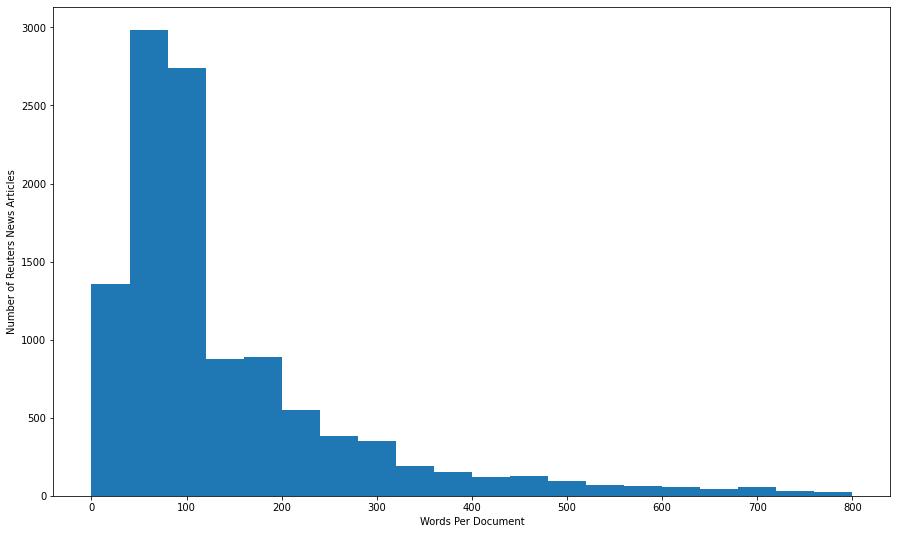

In [24]:
plt.figure(figsize=[15,9])
plt.hist(doc_sizes, bins=20,range = (0,800))
plt.xlabel("Words Per Document")
plt.ylabel("Number of Reuters News Articles")

Distribution is right screwed, most of the words contained with the first couple hundred documents

## Preprocess Reuters Dataset

Decisions resulting from EDA<br>
Input Vector size from document length (maxlen)<br>
Skip Top 25 words - as non-informative (skip_top)

In [25]:
voc_size=10500

<div class="alert alert-block alert-info">
<b>tf.keras.datasets.reuters.load_data</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data
</div>

In [26]:
(train_data, train_labels),(test_data, test_labels) = tf.keras.datasets.reuters.load_data(
                                      path='reuters.npz', num_words=voc_size, skip_top=26, maxlen=300, test_split=0.2,
                                      seed=113, start_char=1, oov_char=2, index_from=3)

### Review Data (Training / Test)

In [27]:
train_labels.shape, test_labels.shape

((7976,), (1994,))

### Review training and testing split of words 

In [28]:
train_data_sizes = [len(s) for s in train_data]
test_data_sizes = [len(s) for s in test_data]

In [29]:
f"There are {sum(train_data_sizes)} words in the training data corpus"

'There are 827922 words in the training data corpus'

In [30]:
f"There are {sum(test_data_sizes)} words in the test data corpus"

'There are 206813 words in the test data corpus'

### Padding Input Vector (Sequences) 

This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.<br>

Sequences that are shorter than num_timesteps are padded with value until they are num_timesteps long.<br>

Sequences longer than num_timesteps are truncated so that they fit the desired length.<br>

The position where padding or truncation happens is determined by the arguments padding and truncating, respectively. Pre-padding or removing values from the beginning of the sequence is the default.<br>

<div class="alert alert-block alert-info">
<b>tf.keras.preprocessing.sequence.pad_sequences</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
</div>

In [31]:
train_data_rnn = tf.keras.preprocessing.sequence.pad_sequences(train_data, padding='post')
test_data_rnn = tf.keras.preprocessing.sequence.pad_sequences(test_data, padding='post')

In [32]:
train_data_rnn.shape, test_data_rnn.shape

((7976, 299), (1994, 299))

### One Hot Encoding Labels

We will change the way this label is represented from a class name or number, to a vector of all possible classes with all the classes set to 0 except the one which this example belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 3 | [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] |
| 4 | [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] |
| 5 | [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] |

In [33]:
train_labels_encoded = to_categorical(train_labels)
test_labels_encoded = to_categorical(test_labels)

print("First ten entries of train_labels:\n {}\n".format(train_labels[0:5]))
print("First ten rows of one-hot train_labels:\n {}".format(train_labels_encoded[0:5,]))

First ten entries of train_labels:
 [3 4 3 4 4]

First ten rows of one-hot train_labels:
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Build SimpleRNN Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/SimpleRNNArchitecture.png?raw=1">

In [100]:
def create_model(voc_size=10500, units=256):
    # Create model
    model = Sequential()
    model.add(Embedding(input_dim=voc_size, output_dim=128, input_length=299))
    model.add(SimpleRNN(units=units,activation='tanh',use_bias=True))
    model.add(Dense(units=46, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

# grid search parameters
units = [16,32,64,128,256]
epochs = [10]
batches = [512]

param_grid = dict(
    units=units,
    nb_epoch=epochs,
    batch_size=batches,
)
grid_result = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(train_data_rnn, train_labels_encoded)
print_results(grid_result)

16/16 [==============================] - 4s 232ms/step - loss: 3.5302 - accuracy: 0.1264


,batch_size,nb_epoch,units,mean_test_score,std_test_score,mean_fit_time
0,512,10,16,0.381770,0.008245,3.042406
2,512,10,64,0.381770,0.008245,4.329580
3,512,10,128,0.381770,0.008245,6.435159
4,512,10,256,0.323853,0.073995,10.885577
1,512,10,32,0.254028,0.171933,3.770699


In [124]:
model = Sequential()
model.add(Embedding(input_dim=voc_size, output_dim=128, input_length=299))
model.add(SimpleRNN(units=16,activation='tanh',use_bias=True))
model.add(Dense(units=46, activation='softmax'))

In [125]:
model.summary()

Model: "sequential_218"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_182 (Embedding)    (None, 299, 128)          1344000   
_________________________________________________________________
simple_rnn_36 (SimpleRNN)    (None, 16)                2320      
_________________________________________________________________
dense_163 (Dense)            (None, 46)                782       
Total params: 1,347,102
Trainable params: 1,347,102
Non-trainable params: 0
_________________________________________________________________


### Calculate the Number of Parameters Per Layer
<div class="alert alert-block alert-success">
    <b>Embedding Parameters</b> = num_words(10500) * size of output (128)<br> 
<b>RNN Parameters</b> = [(size_of_input + 1) * size_of_output + size_of_output^2)]<br>
<b>Dense Layer</b> = size of input(256+1) * size of output(46)
</div>

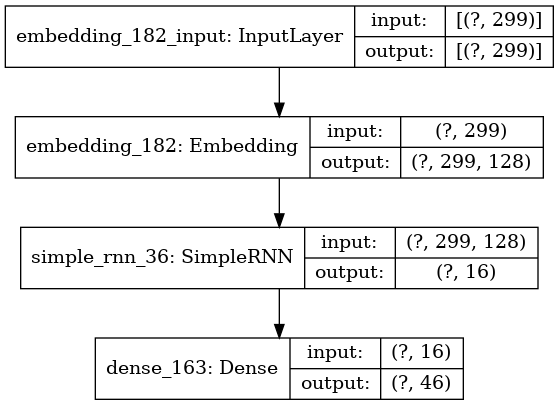

In [126]:
keras.utils.plot_model(model, "SimpleRNN_model.png", show_shapes=True) 

### Compile SimpleRNN Model

In [127]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Define Callback - Training Time Statistics

In [128]:
class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

### Training SimpleRNN Model

In [129]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_data_rnn,
                    train_labels_encoded,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=128,
                    validation_split = 0.15)   

Epoch 1/10
53/53 [==============================] - 4s 74ms/step - loss: 2.9886 - accuracy: 0.3678 - val_loss: 2.5098 - val_accuracy: 0.3751
Epoch 2/10
53/53 [==============================] - 4s 72ms/step - loss: 2.3860 - accuracy: 0.3829 - val_loss: 2.3399 - val_accuracy: 0.3751
Epoch 3/10
53/53 [==============================] - 4s 73ms/step - loss: 2.3185 - accuracy: 0.3829 - val_loss: 2.3259 - val_accuracy: 0.3751
Epoch 4/10
53/53 [==============================] - 4s 72ms/step - loss: 2.3105 - accuracy: 0.3829 - val_loss: 2.3243 - val_accuracy: 0.3751
Epoch 5/10
53/53 [==============================] - 4s 75ms/step - loss: 2.3090 - accuracy: 0.3829 - val_loss: 2.3248 - val_accuracy: 0.3751
Epoch 6/10
53/53 [==============================] - 4s 71ms/step - loss: 2.3087 - accuracy: 0.3829 - val_loss: 2.3258 - val_accuracy: 0.3751
Epoch 7/10
53/53 [==============================] - 4s 70ms/step - loss: 2.3080 - accuracy: 0.3829 - val_loss: 2.3269 - val_accuracy: 0.3751
Epoch 8/10
53

### Training Time Statistics SimpleRNN

In [130]:
train_time = (train_rt.process_time/60)
train_time

0.6780374166666667

### Test SimpleRNN Model

In [131]:
loss, accuracy = model.evaluate(test_data_rnn, test_labels_encoded)
print('test set accuracy: ', accuracy * 100)

63/63 [==============================] - 1s 14ms/step - loss: 2.3116 - accuracy: 0.3967
test set accuracy:  39.66900706291199


### Plotting Performance Metrics SimpleRNN

In [132]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [133]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

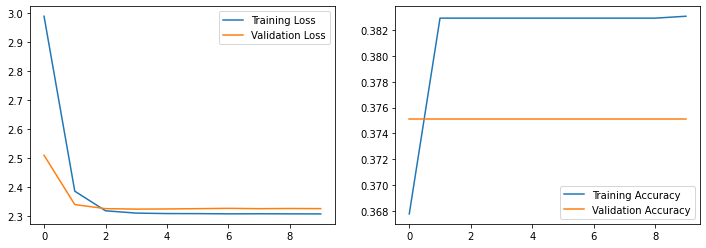

In [134]:
plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Build DNN Model


In [101]:
def create_model(units=256):
    # Create model
    model = Sequential([
        Dense(name = "hidden_layer", units = units, activation = tf.nn.relu, input_shape = (299,)),
        Dense(name = "output_layer", units = 46, activation = tf.nn.softmax)
    ])

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

# grid search parameters
units = [16,32,64,128,256]
epochs = [10]
batches = [512]

param_grid = dict(
    units=units,
    nb_epoch=epochs,
    batch_size=batches,
)
grid_result = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(train_data_rnn, train_labels_encoded)
print_results(grid_result)

16/16 [==============================] - 0s 5ms/step - loss: 947.5812 - accuracy: 0.1878


,batch_size,nb_epoch,units,mean_test_score,std_test_score,mean_fit_time
4,512,10,256,0.248117,0.014325,0.443888
3,512,10,128,0.213638,0.031576,0.438881
2,512,10,64,0.170508,0.019500,0.416545
1,512,10,32,0.090148,0.015636,0.394186
0,512,10,16,0.051653,0.040040,0.432803


In [135]:
model = Sequential([
    Dense(name = "hidden_layer", units = 512, activation = tf.nn.relu, input_shape = (299,)),
    Dense(name = "output_layer", units = 46, activation = tf.nn.softmax)
])

In [136]:
model.summary()

Model: "sequential_219"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 512)               153600    
_________________________________________________________________
output_layer (Dense)         (None, 46)                23598     
Total params: 177,198
Trainable params: 177,198
Non-trainable params: 0
_________________________________________________________________


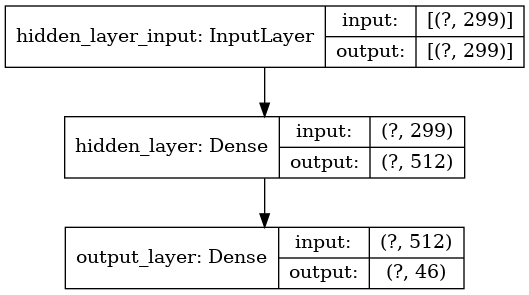

In [137]:
keras.utils.plot_model(model, "DNN_model.png", show_shapes=True) 

In [138]:
model.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [139]:
history = model.fit(
    train_data_rnn,
    train_labels_encoded,
    epochs = 10,
    validation_split=0.20 
    )

Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 545.4011 - accuracy: 0.2909 - val_loss: 334.6160 - val_accuracy: 0.3296
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 168.4264 - accuracy: 0.4201 - val_loss: 219.2202 - val_accuracy: 0.3590
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 73.3156 - accuracy: 0.5431 - val_loss: 193.3658 - val_accuracy: 0.3296
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 39.2053 - accuracy: 0.6440 - val_loss: 183.5644 - val_accuracy: 0.3496
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 26.3431 - accuracy: 0.7092 - val_loss: 181.2459 - val_accuracy: 0.3647
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 19.5898 - accuracy: 0.7498 - val_loss: 183.2440 - val_accuracy: 0.3477
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 16.9785 - accuracy: 0.7887 - val_loss: 184.6538 - val_

In [140]:
train_time = (train_rt.process_time/60)
train_time

0.6780374166666667

In [141]:
loss, accuracy = model.evaluate(test_data_rnn, test_labels_encoded)
print('test set accuracy: ', accuracy * 100)

63/63 [==============================] - 0s 1ms/step - loss: 191.8957 - accuracy: 0.4007
test set accuracy:  40.07021188735962


In [142]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [143]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

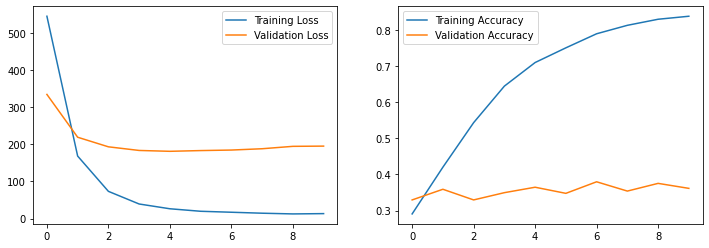

In [144]:
plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Build LSTM Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/LSTMcellArchitecture.png?raw=1">

In [93]:
(train_data, LSTMtrain_labels),(test_data, LSTMtest_labels) = tf.keras.datasets.reuters.load_data(
                                      path='reuters.npz', num_words=30980, skip_top=26, maxlen=2376, test_split=0.2,
                                      seed=113, start_char=1, oov_char=2, index_from=26)

In [94]:
LSTMtrain_data_rnn = tf.keras.preprocessing.sequence.pad_sequences(train_data,maxlen=1032)
LSTMtest_data_rnn = tf.keras.preprocessing.sequence.pad_sequences(test_data,maxlen=1032)
LSTMtrain_encoded = to_categorical(LSTMtrain_labels)
LSTMtest_encoded = to_categorical(LSTMtest_labels)

In [95]:
LSTMtrain_data_rnn.shape, LSTMtest_data_rnn.shape

((8981, 1032), (2246, 1032))

In [98]:
def create_model(units=256):
    # Create model
    model= Sequential()
    model.add(Embedding(input_dim=30980, output_dim=256, input_length=1032))
    model.add(LSTM(units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 46, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

# grid search parameters
units = [16,32,64,128,256]
epochs = [10]
batches = [64]

param_grid = dict(
    units=units,
    nb_epoch=epochs,
    batch_size=batches,
)
grid_result = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(LSTMtrain_data_rnn, LSTMtrain_encoded)
print_results(grid_result)

141/141 [==============================] - 96s 684ms/step - loss: 2.1101 - accuracy: 0.4587


,batch_size,nb_epoch,units,mean_test_score,std_test_score,mean_fit_time
2,64,10,64,0.514307,0.006845,58.144478
1,64,10,32,0.491931,0.048861,45.593892
0,64,10,16,0.474450,0.027216,37.077223
4,64,10,256,0.456076,0.033665,276.502697
3,64,10,128,0.448954,0.041282,108.666509


In [104]:
LSTMmodel= Sequential()
LSTMmodel.add(Embedding(input_dim=30980, output_dim=256, input_length=1032))
LSTMmodel.add(LSTM(units = 64))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(units = 46, activation='softmax'))

In [105]:
LSTMmodel.summary()

Model: "sequential_216"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_180 (Embedding)    (None, 1032, 256)         7930880   
_________________________________________________________________
lstm_125 (LSTM)              (None, 64)                82176     
_________________________________________________________________
dropout_144 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_161 (Dense)            (None, 46)                2990      
Total params: 8,016,046
Trainable params: 8,016,046
Non-trainable params: 0
_________________________________________________________________


### Calculate the Number of Parameters Per Layer
Embedding Parameters = num_words(30980) * size of output (256)<br> 
LSTM Parameters = 4 * [(size_of_input + 1) * size_of_output + size_of_output^2)]<br>
Dense Layer = size of input(256+1) * size of output(46) 

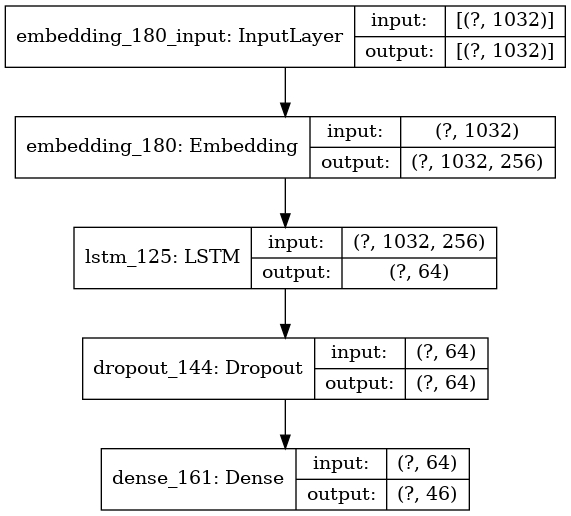

In [106]:
keras.utils.plot_model(LSTMmodel, "LSTM_model.png", show_shapes=True) 

### Compile LSTM Model

In [107]:
LSTMmodel.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training LSTM Model

In [108]:
train_rt = TrainRuntimeCallback()
history = LSTMmodel.fit(LSTMtrain_data_rnn,
                    LSTMtrain_encoded,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=64,
                    validation_split = 0.15) 

Epoch 1/10
120/120 [==============================] - 79s 656ms/step - loss: 2.2269 - accuracy: 0.4465 - val_loss: 1.8520 - val_accuracy: 0.5104
Epoch 2/10
120/120 [==============================] - 74s 614ms/step - loss: 1.7380 - accuracy: 0.5424 - val_loss: 1.7099 - val_accuracy: 0.5282
Epoch 3/10
120/120 [==============================] - 73s 605ms/step - loss: 1.5330 - accuracy: 0.5876 - val_loss: 1.5664 - val_accuracy: 0.5942
Epoch 4/10
120/120 [==============================] - 72s 603ms/step - loss: 1.3290 - accuracy: 0.6549 - val_loss: 1.5257 - val_accuracy: 0.6335
Epoch 5/10
120/120 [==============================] - 73s 609ms/step - loss: 1.1364 - accuracy: 0.7189 - val_loss: 1.7037 - val_accuracy: 0.6365
Epoch 6/10
120/120 [==============================] - 72s 602ms/step - loss: 1.0059 - accuracy: 0.7465 - val_loss: 1.4137 - val_accuracy: 0.6662
Epoch 7/10
120/120 [==============================] - 73s 605ms/step - loss: 0.8764 - accuracy: 0.7806 - val_loss: 1.6278 - val_ac

### Training Time Statistics LSTM 

In [109]:
LSTMtrain_time = (train_rt.process_time/60)
LSTMtrain_time

12.335847416666667

### Test LSTM Model

In [110]:
loss, accuracy = LSTMmodel.evaluate(LSTMtest_data_rnn, LSTMtest_encoded)
print('test set accuracy: ', accuracy * 100)

71/71 [==============================] - 6s 86ms/step - loss: 1.4991 - accuracy: 0.6808
test set accuracy:  68.07658076286316


### Plotting Performance Metrics LSTM

In [111]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [112]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

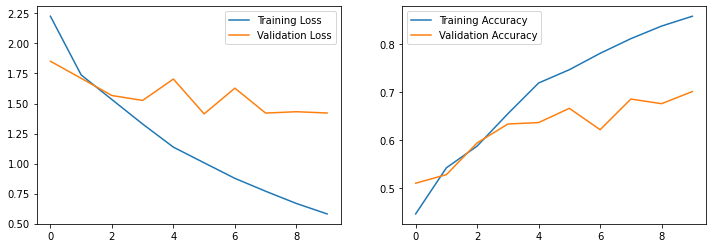

In [113]:
plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Build CNN Model

In [103]:
def create_model(filters=256):
    # Create model
    model = Sequential()
    model.add(Embedding(input_dim=30980, output_dim=256, input_length=1032))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=filters, kernel_size=3, padding='valid', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(32))
    model.add(Dense(units= 46, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

# grid search parameters
filters = [16,32,64,128,256]
epochs = [10]
batches = [64]

param_grid = dict(
    filters=filters,
    nb_epoch=epochs,
    batch_size=batches,
)
grid_result = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(LSTMtrain_data_rnn, LSTMtrain_encoded)
print_results(grid_result)

141/141 [==============================] - 43s 303ms/step - loss: 2.8170 - accuracy: 0.3748


,batch_size,filters,nb_epoch,mean_test_score,std_test_score,mean_fit_time
1,64,32,10,0.357977,0.013117,31.839065
3,64,128,10,0.352967,0.005925,40.036664
0,64,16,10,0.351742,0.004453,29.498644
4,64,256,10,0.308642,0.062979,58.061198
2,64,64,10,0.308196,0.062625,33.166842


In [114]:
model = Sequential()
model.add(Embedding(input_dim=30980, output_dim=256, input_length=1032))
model.add(Dropout(0.25))
model.add(Conv1D(filters=32, kernel_size=3, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(64))
model.add(Dense(units= 46, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [115]:
model.summary()

Model: "sequential_217"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_181 (Embedding)    (None, 1032, 256)         7930880   
_________________________________________________________________
dropout_145 (Dropout)        (None, 1032, 256)         0         
_________________________________________________________________
conv1d_90 (Conv1D)           (None, 1030, 32)          24608     
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 257, 32)           0         
_________________________________________________________________
lstm_126 (LSTM)              (None, 64)                24832     
_________________________________________________________________
dense_162 (Dense)            (None, 46)                2990      
Total params: 7,983,310
Trainable params: 7,983,310
Non-trainable params: 0
__________________________________________

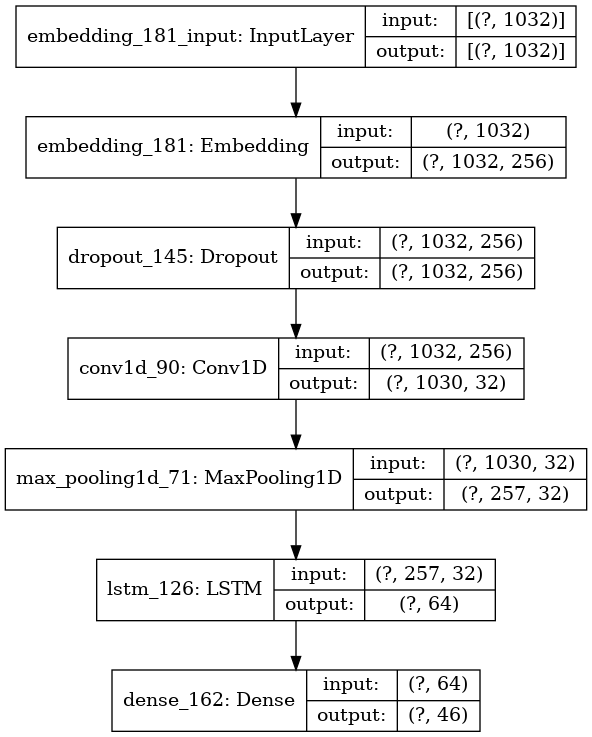

In [116]:
keras.utils.plot_model(model, "Conv1Dmodel_model.png", show_shapes=True) 

In [117]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [118]:
train_rt = TrainRuntimeCallback()
history = model.fit(LSTMtrain_data_rnn,
                    LSTMtrain_encoded,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=64,
                    validation_split = 0.15) 

Epoch 1/10
120/120 [==============================] - 44s 370ms/step - loss: 2.6744 - accuracy: 0.3519 - val_loss: 2.4284 - val_accuracy: 0.3435
Epoch 2/10
120/120 [==============================] - 46s 382ms/step - loss: 2.1317 - accuracy: 0.3693 - val_loss: 1.9788 - val_accuracy: 0.3858
Epoch 3/10
120/120 [==============================] - 46s 382ms/step - loss: 1.7888 - accuracy: 0.4664 - val_loss: 1.7243 - val_accuracy: 0.5423
Epoch 4/10
120/120 [==============================] - 46s 382ms/step - loss: 1.5238 - accuracy: 0.5889 - val_loss: 1.6564 - val_accuracy: 0.5720
Epoch 5/10
120/120 [==============================] - 46s 381ms/step - loss: 1.3436 - accuracy: 0.6417 - val_loss: 1.5954 - val_accuracy: 0.5987
Epoch 6/10
120/120 [==============================] - 45s 375ms/step - loss: 1.2110 - accuracy: 0.6784 - val_loss: 1.3907 - val_accuracy: 0.6499
Epoch 7/10
120/120 [==============================] - 45s 376ms/step - loss: 1.0844 - accuracy: 0.7076 - val_loss: 1.3560 - val_ac

In [119]:
modeltrain_time = (train_rt.process_time/60)
modeltrain_time

7.647096033333333

In [120]:
loss, accuracy = LSTMmodel.evaluate(LSTMtest_data_rnn, LSTMtest_encoded)
print('test set accuracy: ', accuracy * 100)

71/71 [==============================] - 6s 91ms/step - loss: 1.4991 - accuracy: 0.6808
test set accuracy:  68.07658076286316


In [121]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [122]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

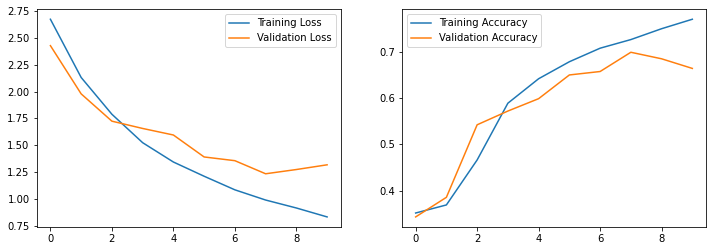

In [123]:
plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()